# About this notebook

This notebook is based off of the [Signals](https://github.com/makeabilitylab/signals/tree/master/Projects/GestureRecognizer) repository by Jon Froehlich. Much of the data and code used in this notebook is originally from Jon's work, but additional novel expansions are added. 

This notebook uses 3d accelerometer data to classify gestures made by a user. The users pre-recorded the different classes of gestures ahead of time while holding the accelerometer device. This accelerometer data is then preprocessed and used for feature engineering, ultimately being used for supervised machine learning using classical machine learning algorithms. 

# Imports

In [1]:
import itertools
import math
import os
import random

from joblib import Memory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from fastdtw import fastdtw
from pprint import pprint
from scipy import signal
from scipy.spatial import distance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score,
                            confusion_matrix, silhouette_score)
from sklearn.model_selection import (LeaveOneGroupOut, StratifiedKFold,
                                     cross_val_predict, cross_val_score,
                                     cross_validate, train_test_split,
                                    GridSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import gesturerec.data as grdata
import gesturerec.utility as grutils
import gesturerec.vis as grvis
from gesturerec.data import GestureSet, SensorData

In [2]:
%matplotlib inline

# Load the data 

This notebook runs on the following unified datasets:
 - All uploaded gestures from the Winter 2024 UbiComp class
 - My personal recorded gestures
    1. Standard set of 5 trials per gesture
    2. Medium speed set of 25 trials per gesture
    3. Fast speed set of 25 trials per gesture
    4. Slow speed set of 25 trials per gesture
 - The original Signals repository gestures
 - The Signals repository gestures recorded on the ADXL335GestureLogs

In [3]:
%%capture 
# %%capture hides the cell output to keep things tidy
root_gesture_log_path = './GestureLogs'

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

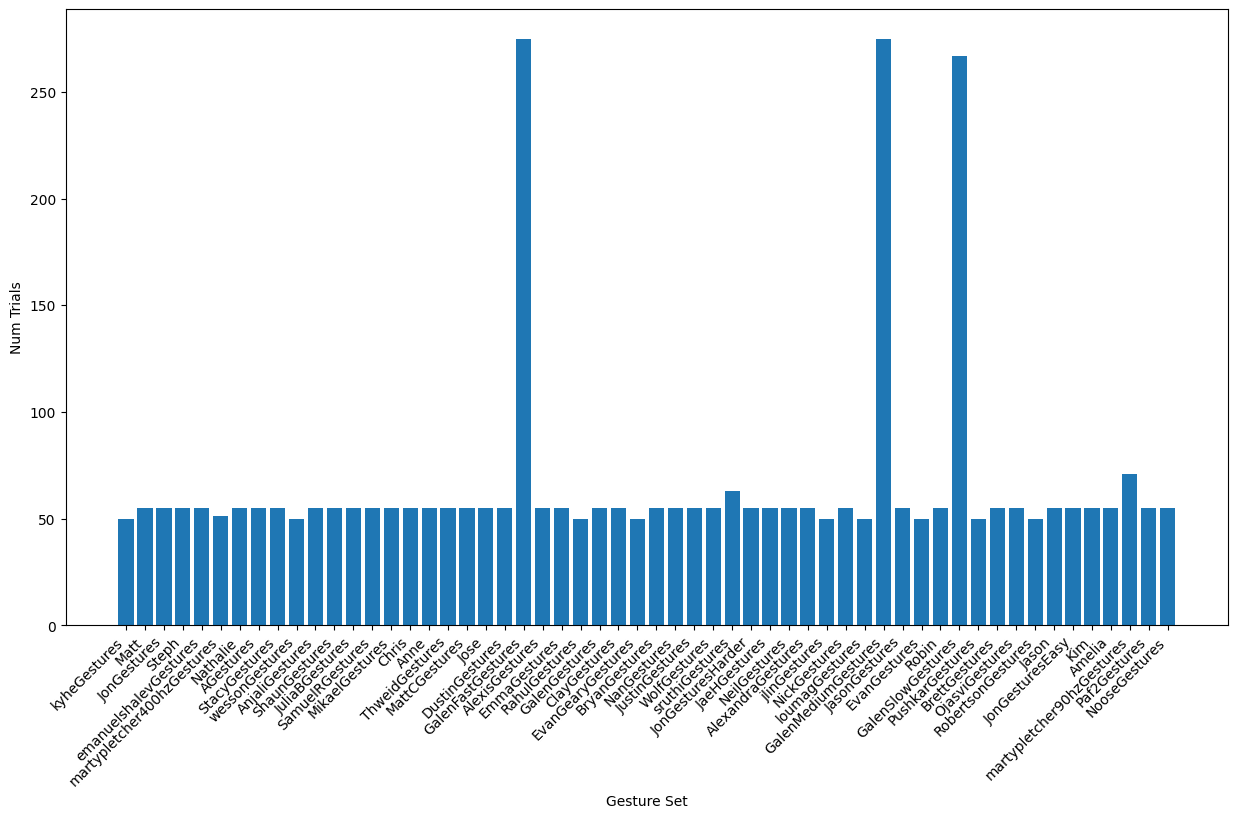

In [4]:
names = []
n_trials = []
for gesture_set_name, gesture_set in map_gesture_sets.items():
    names.append(gesture_set_name)
    n_trials.append(len(gesture_set.get_all_trials()))

plt.figure(figsize=(15, 8))
plt.bar(names, n_trials)
plt.xlabel('Gesture Set')
plt.ylabel('Num Trials')
plt.xticks(rotation=45, ha='right')
plt.show()

In [5]:
list_of_feature_vectors = []
all_feature_names = []
for gesture_set in map_gesture_sets.values():
    gesture_names = gesture_set.get_gesture_names_sorted()
    
    for gesture_name in gesture_names:
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        
        for trial in gesture_trials:
            features, feature_names = [], []

            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")

            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trial_num)
            feature_names.append("trial_num")
            
            features.append(trial.accel.x)
            feature_names.append("x")

            features.append(trial.accel.y)
            feature_names.append("y")

            features.append(trial.accel.z)
            feature_names.append("z")

            features.append(trial.accel.mag)
            feature_names.append("mag")

            features.append(trial.accel.sampling_rate)
            feature_names.append("sampling_rate")
            
            list_of_feature_vectors.append(features)
            all_feature_names.append(feature_names)

all_feature_names = all_feature_names[0] #not elegant but didnt want to deal with first-pass logic
df = pd.DataFrame(list_of_feature_vectors, columns=all_feature_names)
df.shape

(3707, 8)

In [6]:
df.sample(5, random_state=0)

,gesturer,gesture,trial_num,x,y,z,mag,sampling_rate
1032,Jose,At Rest,1,"[404.0, 404.0, 405.0, 405.0, 405.0, 404.0, 404...","[318.0, 317.0, 317.0, 317.0, 318.0, 317.0, 317...","[351.0, 351.0, 352.0, 352.0, 353.0, 352.0, 352...","[622.5279110208634, 622.017684636056, 623.2318...",77.016129
3034,GalenSlowGestures,OverheadWave,5,"[-4272.0, -4240.0, -4192.0, -4192.0, -4160.0, ...","[-5264.0, -5168.0, -5136.0, -5072.0, -5184.0, ...","[3408.0, 3376.0, 3376.0, 3392.0, 3568.0, 3792....","[7587.76277963406, 7488.871744128083, 7439.673...",100.213675
3320,Jason,Baseball Throw,4,"[439.0, 438.0, 438.0, 437.0, 438.0, 438.0, 438...","[536.0, 535.0, 534.0, 534.0, 533.0, 532.0, 534...","[581.0, 582.0, 582.0, 581.0, 581.0, 581.0, 581...","[904.20019907098, 903.7660095400801, 903.17440...",73.183761
2427,GalenMediumGestures,Backhand Tennis,8,"[-4704.0, -4672.0, -4640.0, -4544.0, -4672.0, ...","[-5264.0, -5408.0, -5504.0, -5504.0, -5600.0, ...","[3392.0, 3440.0, 3376.0, 3232.0, 3280.0, 3216....","[7832.175687508548, 7931.434170438534, 7951.16...",100.470286
1366,GalenFastGestures,Shake,0,"[-6736.0, -6384.0, -7104.0, -10416.0, -13184.0...","[21232.0, 15584.0, 7392.0, 4224.0, -832.0, -88...","[-13744.0, -13456.0, -8992.0, -3904.0, 2400.0,...","[26173.823870424436, 21556.44794487255, 13636....",100.892857


Now that we have the raw sensor data into Pandas, let's do some preprocessing. 

I know firsthand that there are at least a handful of trials with bunk data. This is because my microprocessor came unplugged while I was violently swinging it around. We'll want to find any trials with `0.0` values for all of the sensor data and drop them from the dataframe.

In [7]:
sensor_cols = ['x', 'y', 'z', 'mag']
# Find rows where one of the arrays contains NaN or null
rows_with_nan = df[df[sensor_cols].apply(lambda x: pd.Series(x).apply(lambda arr: np.any(pd.isna(arr)))).any(axis=1)]
rows_with_all_zeros = df[df[sensor_cols].apply(lambda x: np.all(x.apply(lambda arr: np.all(arr == 0.0))), axis=1)]
df = df.drop(rows_with_all_zeros.index)
df = df.drop(rows_with_nan.index)
df.shape # we dropped 3 trials

(3704, 8)

# Preprocess the data

We'll be using z-score normalization for this data. More work could be done to use z-score thresholding to remove outlier trials, but things get a little tricky because you'd need to compare the z-score for a given trial sensor data stream to the average sensor data stream for that gesture. For now, we'll just normalize and leave any outliers in the dataset. 

We'll use z-score normalization again with the `sklearn.preprocessing.StandardScaler`, but doing it now on the raw data helps us to remove a few trials. 

In [8]:
# normalize sensor data using z-score
df[sensor_cols] = df[sensor_cols].map(lambda arr: sp.stats.zscore(arr))
df.sample(5, random_state=0)

,gesturer,gesture,trial_num,x,y,z,mag,sampling_rate
1032,Jose,At Rest,1,"[-0.20787190788675103, -0.20787190788675103, 1...","[2.3377385121992194, 0.8241518822668679, 0.824...","[-1.109858347102835, -1.109858347102835, 0.559...","[0.4062223545513016, -0.2286267258652248, 1.28...",77.016129
3035,GalenSlowGestures,OverheadWave,6,"[-1.7143118857798585, -1.7143118857798585, -1....","[-0.4948740716530022, -0.524188912878304, -0.5...","[0.6478287073958042, 0.6331057260313262, 0.625...","[-0.3256791989462006, -0.29235335755024616, -0...",100.214746
2799,Robin,Midair 'S',0,"[0.14444098426623536, 0.14444098426623536, 0.1...","[0.005773510061954553, 0.005773510061954553, 0...","[-0.2814206678938347, -0.26638244595094906, -0...","[-0.1776768526631445, -0.16917838529953033, -0...",76.653944
2063,JonGesturesHarder,Midair Zorro 'Z',4,"[-0.5174849305401076, -0.48915714585753306, -0...","[-0.0323740865781102, -0.04024068705503413, -0...","[-0.013914060467302355, -0.013914060467302355,...","[-0.4587323484474362, -0.45055616656249065, -0...",76.765841
1366,GalenFastGestures,Shake,0,"[-0.6515303066616386, -0.6069815321866721, -0....","[1.2193488278652875, 0.935020616982182, 0.5226...","[-1.5734610963886626, -1.5483001672069574, -1....","[0.3580072782450185, -0.04875240954267092, -0....",100.892857


A few other rows cause an issue with the `At Rest` gesture. This is because the values for certain axis are essentially the same. We'll drop a few of these too. 

In [9]:
# find problem rows after z-score
rows_with_nan = df[df[sensor_cols].apply(lambda x: pd.Series(x).apply(lambda arr: np.any(pd.isna(arr)))).any(axis=1)]
rows_with_nan

,gesturer,gesture,trial_num,x,y,z,mag,sampling_rate
2019,JonGesturesHarder,At Rest,0,"[0.05089865985591719, 0.05089865985591719, 0.0...","[0.1586365749563947, 0.1586365749563947, 0.158...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.1666570030580231, 0.1666570030580231, 0.166...",76.618491
2020,JonGesturesHarder,At Rest,1,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.25920889205446224, 0.25920889205446224, -3....","[0.25920889205399195, 0.25920889205399195, -3....",76.607717
3307,Jason,At Rest,1,"[-0.08574929257157125, -0.08574929257157125, -...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.6431920864232646, 0.6431920864232646, 0.643...","[0.6531037444611829, 0.6531037444611829, 0.653...",73.183761
3308,Jason,At Rest,2,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.08512565307575873, -0.08512565307575873, -...","[-1.9061304607326597, 0.5246230625871151, -1.9...","[-1.8806611739320205, 0.49990907144721974, -1....",73.157895


In [10]:
df = df.drop(rows_with_nan.index)
df.shape

(3700, 8)

Lastly, let's smooth out our normalized sensor data. 

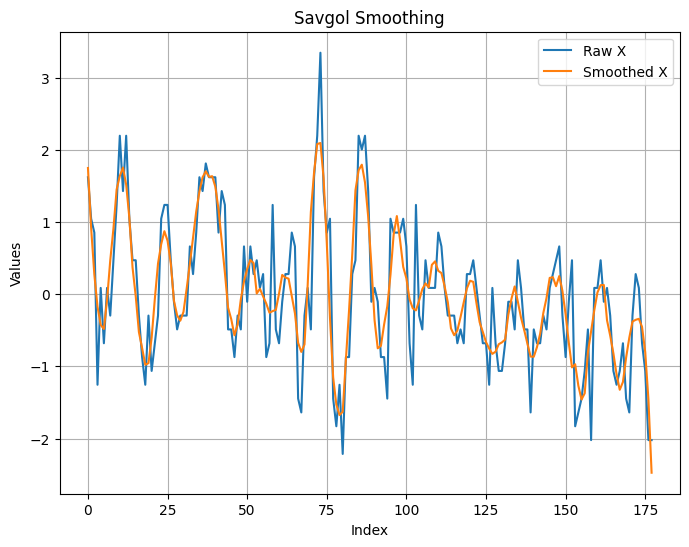

In [11]:
old_x = df['x'][0].copy()

# Smoothing function using scipy's savgol_filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
def smooth_array(arr, window_length=10, polyorder=3):
    smoothed_arr = sp.signal.savgol_filter(arr, window_length, polyorder)
    return smoothed_arr

for column in sensor_cols:
    df[column] = df[column].apply(lambda arr: smooth_array(arr))


plt.figure(figsize=(8, 6))
plt.plot(old_x, label='Raw X')
plt.plot(df['x'][0], label='Smoothed X')
plt.title('Savgol Smoothing')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Shape Matching Pipeline

## Class Cleanup
- There is a major source of error in this project, which is that there are numerous gesture sets by different gesturers, but all under the label `Custom`. When they recorded the gestures, they did not changed the code to give the gesture a custom name, which makes it basically impossible to infer what the gesture actually is without recreating an animation of the points in 3D.
- This means that the `Custom` class is filled with garbage data.
- Let's remove it entirely. 

In [12]:
# Remove Custom
df = df[~df['gesture'].isin(['Custom'])]

y = df.pop('gesture')
X = df

## Distance Metrics

We're going to define a few custom distance metrics:
1. Raw Euclidean distance of the X vector
2. Raw Euclidean distance of the Y vector
3. Raw Euclidean distance of the Z vector
4. Raw Euclidean distance of the magnitude vector
5. Dynamic Time Warping distance

We'll compute these distance metrics for each training sample and compare them to the a synthetic template derived from the test fold. The template will be created using the average values for all samples of that gesture class within the test fold. 

In [127]:
def euclidean_x(template, sample):
    print(template['x'].iloc[0].shape)
    print(sample['x'].shape)
    padding(template, sample, 'x')
    print(template['x'].iloc[0].shape)
    print(sample['x'].shape)
    return distance.euclidean(et, es)

def euclidean_y(template, sample):
    return distance.euclidean(template['y'], sample['y'])

def euclidean_z(template, sample):
    return distance.euclidean(template['z'], sample['z'])

def euclidean_mag(template, sample):
    return distance.euclidean(template['mag'], sample['mag'])

def dtw(template, sample):
    return fastdtw(template, sample)[0] # only return distance

In [92]:
class ShapeMatchingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, shape_matching_function):
        self.shape_matching_function = shape_matching_function
        self.templates_ = None
        self.distances = None
    
    def predict(self, X, y=None):
        if self.distances is None:
            raise ValueError("ShapeMatchingTransformer.fit() must be run to produce distances before predition can happen.")
        print(self.distances)
        # Find the index of the template with the minimum distance for each sample
        labels = np.argmin(self.distances, axis=0)
        return labels.reshape(-1, 1)

    def fit(self, X, y=None, templates=None):
        if templates is None:
            raise ValueError("Templates must be provided for fitting.")
        
        # Set the templates provided
        self.templates_ = templates
        # For each template, compute the distance to each sample in X
        self.distances = np.array([
            [self.shape_matching_function(template, sample) for _, sample in X.iterrows()]
            for template in self.templates_
        ])
        return self

In [93]:
def average_sample(arrays):
    # Pad each trial sample to the max len and then calculate the mean
    max_length = max(len(arr) for arr in arrays)
    padded_arrays = [np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=np.nan) for arr in arrays]
    return np.nanmean(padded_arrays, axis=0)

In [126]:
def padding(template, sample, col):
    tl = len(template[col])
    sl = len(sample[col])
    array_length_diff = abs(tl - sl)
    if tl > sl:
        sample[col] = sample[col].apply(lambda x: np.pad(x, (0, array_length_diff), 'constant', constant_values=np.nan))
    else:
        print(template[col].iloc[0].shape)
        template[col] = template[col].apply(lambda x: np.pad(x, (0, array_length_diff), 'constant', constant_values=np.nan))
        print(template[col].iloc[0].shape)

## Define the pipeline

## I could maybe skip all this crap if i just made "templates" from JonGestures and didn't fuck around with Kfolds and generating templates on the fly

In [129]:
seed = 42 # used for random state in several places
k    = 10 # number of folds

# Create train-test split. We will use the test split for a final evaluation (10% holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

shape_matching_functions = [euclidean_x, euclidean_y, euclidean_z, euclidean_mag, dtw]
pipelines = list()
scores = list()

for shape_matching_function in shape_matching_functions:
    pipeline = Pipeline([
        ('shape_matching', ShapeMatchingTransformer(shape_matching_function))
    ])
    pipelines.append(pipeline) # run a separate Pipeline for each distance function

for i, pipeline in enumerate(pipelines):
    kf_accuracy = list()
    for train_index, test_index in kf.split(X_train, y_train):
        # Get the test fold for each cross-validation
        Xkf_train, Xkf_test = X_train.iloc[train_index], X_train.iloc[test_index] 
        ykf_train, ykf_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Generate templates based just off the kfolds test split
        templates = [Xkf_test.loc[ykf_test == label, ["x", "y", "z", "mag"]] for label in np.unique(ykf_test)]
        
        # Get the average value for each column, for each gesture
        for t in templates:
            t['x'] = t['x'].apply(lambda x: average_sample([x]))
            t['y'] = t['y'].apply(lambda y: average_sample([y]))
            t['z'] = t['z'].apply(lambda z: average_sample([z]))
            t['mag'] = t['mag'].apply(lambda mag: average_sample([mag]))

        # Fit to generate distances
        pipeline.named_steps['shape_matching'].fit(Xkf_train, ykf_train, templates=templates)
        ykf_pred = pipeline.named_steps['shape_matching'].predict(Xkf_test)


        # Evaluate accuracy
        kf_acc = accuracy_score(ykf_test, ykf_pred)
        kf_accuracy.append(kf_acc)
    
    score = np.mean(kf_accuracy)
    print(f'Accuracy for {shape_matching_functions[i]}: {score}')
    scores.append(score)

# Save results to disc
results_df = pd.DataFrame(grid_search.cv_results_)
csv_file_path = 'grid_search_results.csv'
results_df.to_csv(csv_file_path, index=False)

(223,)
(178,)
(223,)
(371,)


/home/master/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the holdout set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report   = classification_report(y_test, y_pred)

# Print results
print(f"Best Model:")
pprint(grid_search.best_params_, width=1)
print(f"Overall Accuracy: {accuracy}\n")
print("\n\n")
print("Classification Report:\n", report)

# Exploring the Results
**Note:** If you skipped training the models and want to load results, start here.

In [ ]:
# only load from disc if you don't already have a results dataframe
if results_df.empty or results_df is None:
    try:
        results_df = pd.read_csv(csv_file_path)
        print("Results loaded.")
    except FileNotFoundError:
        print("CSV file not found.")
        print("You will need to double-check for the results csv or go back and retrain the models.")

In [ ]:
# view what features are in each classifier result
results_df.columns

In [ ]:
# Sort the results by mean_test_score in descending order
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)
pd.set_option('display.max_rows', None) # avoid truncated output
pd.set_option('display.max_colwidth', None)

# Display the top results
print("Top Results:")
display(sorted_results[['params', 'mean_test_score', 'std_test_score']].head())

In [ ]:
# Find the row with the best mean_test_score and get params
best_model_row = results_df.loc[results_df['mean_test_score'].idxmax()]
best_model_params = best_model_row['params']
best_model_params

In [ ]:
if best_model_params['classifier'] == RandomForestClassifier():
    best_model = RandomForestClassifier(**best_model_params)
    
elif best_model_params['classifier'] == KNeighborsClassifier():
    best_model = KNeighborsClassifier(**best_model_params)
    
elif best_model_params['classifier'] == DecisionTreeClassifier():
    best_model = DecisionTreeClassifier(**best_model_params)

# Train the model >> we have to do this because we're loading parameters from disc
best_model.fit(X_train, y_train)

# Make predictions on the holdout set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Best Model:")
pprint(grid_search.best_params_, width=1)
print(f"Overall Accuracy: {accuracy}\n")
print("\n\n")
print("Classification Report:\n", report)

There are a couple classes that are not represented in the holdout set. Let's see what things look like if we remove them from the classification report:

In [ ]:
print(classification_report(y_test,y_pred,labels=np.unique(y_pred)))

## Confusion matrix for the entire class (holdout only)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), square=True)
plt.title(f'Confusion Matrix for the holdout set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Confusion matrix for your gesture set

In [ ]:
subset_df = user_df[user_df['gesturer'] == "GalenGestures"]
trial_indices = subset_df.pop("trial_num") 
gesturer = subset_df.pop('gesturer')
y = subset_df.pop('gesture')
X = subset_df

# predict on all the trials for that user
y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred), square=True)
plt.title(f'Confusion Matrix for GalenGestures')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Confusion matrix for Jon's gesture set

In [ ]:
subset_df = user_df[user_df['gesturer'] == "JonGestures"]
trial_indices = subset_df.pop("trial_num") 
gesturer = subset_df.pop('gesturer')
y = subset_df.pop('gesture')
X = subset_df

y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y), yticklabels=np.unique(y), square=True)
plt.title(f'Confusion Matrix for JonGestures')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Confusion Matrix for all gesture sets except for GalenSlow, GalenFast, GalenMedium

In [ ]:
excluded_values = ['GalenSlowGestures', 'GalenMediumGestures', 'GalenMediumGestures']
subset_df = user_df[~user_df['gesturer'].isin(excluded_values)]

trial_indices = subset_df.pop("trial_num") 
gesturer = subset_df.pop('gesturer')
y = subset_df.pop('gesture')
X = subset_df

y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred), square=True)
plt.title(f'Confusion Matrix for all gesture sets != GalenSlow, GalenFast, GalenMedium')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()